# Homework 1

In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!unzip -qq dul_2021/Homework/hw1/data/hw1_data.zip -d dul_2021/Homework/hw1/data/
!mv -v dul_2021/Homework/hw1/data/hw1_data/* dul_2021/Homework/hw1/data/
!rmdir dul_2021/Homework/hw1/data/hw1_data/
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 123, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 123 (delta 48), reused 71 (delta 22), pack-reused 0
Receiving objects: 100% (123/123), 26.19 MiB | 14.02 MiB/s, done.
Resolving deltas: 100% (48/48), done.
renamed 'dul_2021/Homework/hw1/data/hw1_data/geoffrey-hinton.jpg' -> 'dul_2021/Homework/hw1/data/geoffrey-hinton.jpg'
renamed 'dul_2021/Homework/hw1/data/hw1_data/mnist_colored.pkl' -> 'dul_2021/Homework/hw1/data/mnist_colored.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/mnist.pkl' -> 'dul_2021/Homework/hw1/data/mnist.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/shapes_colored.pkl' -> 'dul_2021/Homework/hw1/data/shapes_colored.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/shapes.pkl' -> 'dul_2021/Homework/hw1/data/shapes.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/smiley.jpg' -> 'dul_2021/Homework/hw1/data/smiley.jpg'
Processing ./dul_202

In [2]:
from dul_2021.utils.hw1_utils import *
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm import tqdm

In [3]:
plt.rcParams["axes.labelsize"] = 25.
plt.rcParams["xtick.labelsize"] = 20.
plt.rcParams["ytick.labelsize"] = 20.
plt.rcParams["legend.fontsize"] = 18.

plt.rcParams["figure.figsize"] = [8., 6.]

# MADE

In this question, you will implement [MADE](https://arxiv.org/abs/1502.03509). In the first part, you will use MADE to model a simple 2D joint distribution, and in the second half, you will train MADE on image datasets.

## Part (a) Fitting 2D Data

First, you will work with bivariate data of the form $x = (x_0,x_1)$, where $x_0, x_1 \in \{0, \dots, d\}$. We can easily visualize a 2D dataset by plotting a 2D histogram. Run the cell below to visualize our datasets.

Dataset 1


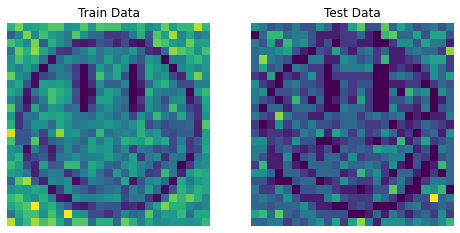

Dataset 2


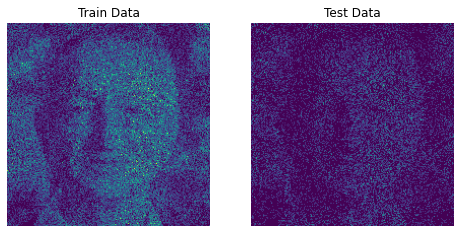

In [4]:
visualize_q1a_data(dset_type=1)
visualize_q1a_data(dset_type=2)
# you can access data with get_data_q1_a(dset_type=1)

Implement and train a MADE model through maximum likelihood to represent $p(x_0, x_1)$ on the given datasets, with any autoregressive ordering of your choosing. 

A few notes:
* You do not need to do training with multiple masks
* You might find it useful to one-hot encode your inputs. 

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Visualize the learned 2D distribution by plotting a 2D heatmap


### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [5]:
dataset = get_data_q1_a(dset_type=1)

In [6]:
def get_dataloader(dataset, batch_size):
    x0 = F.one_hot(torch.tensor(dataset[:, 0], dtype=torch.long)).float()
    x1 = F.one_hot(torch.tensor(dataset[:, 1], dtype=torch.long)).float()
    new_dataset = torch.cat((x0, x1), dim=1)

    return DataLoader(new_dataset, batch_size, pin_memory=True, 
               num_workers=2, shuffle=True)

In [7]:
class MaskedLinear(nn.Linear):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias=bias)
        self.register_buffer('mask', torch.ones(out_features, in_features))

    def __call__(self, x):
        return self.forward(x)

    def forward(self, x):
        return F.linear(x, self.weight * self.mask, self.bias)

    def set_mask(self, mask):
        self.mask.data.copy_(torch.from_numpy(mask.astype(np.uint8).T))

In [8]:
class Model(nn.Module):
    def __init__(self, in_features, out_features, hidden_features):
        super().__init__()

        self.layers = nn.Sequential(
            MaskedLinear(in_features, hidden_features),
            nn.ReLU(),
            MaskedLinear(hidden_features, hidden_features),
            nn.ReLU(),
            MaskedLinear(hidden_features, hidden_features),
            nn.ReLU(),
            MaskedLinear(hidden_features, out_features)
        )
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        z = self.layers(x)
        z = z.reshape(z.shape[0], 2, z.shape[1] // 2)

        return self.softmax(z)

In [20]:
class MADE(nn.Module):
    def __init__(self, in_features, out_features, 
                 hidden_features, hidden_sizes, batch_size=32, 
                 epochs=100, dims=25, lr=1e-3,
                 val_each=10, device="cuda"):
        super().__init__()
        self.hidden_sizes = hidden_sizes
        self.dim = dims
        self.epochs = epochs
        self.device = device
        self.batch_size = batch_size
        self.val_each = val_each
        self.model = Model(in_features, out_features, hidden_features)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)

        self.loss_func = nn.BCELoss()

        self.m = {}
        self.masks = []
        self.update_masks()

        self.train_loss, self.val_loss = [], []
        self.distribution = torch.zeros((self.dim, self.dim), 
                                        dtype=torch.float32)

    def update_masks(self):
        L = len(self.hidden_sizes)
        
        self.m[-1] = np.repeat(np.arange(2), self.dim)
        for l in range(L):
            self.m[l] = np.random.randint(self.m[l-1].min(), 2, 
                                          size=self.hidden_sizes[l])
        
        self.masks = [self.m[l-1][:, np.newaxis] <= 
                 self.m[l][np.newaxis,:] for l in range(L)]
        self.masks.append(self.m[L-1][:, np.newaxis] < self.m[-1][np.newaxis, :])

        layers = [l for l in self.model.modules() 
                            if isinstance(l, MaskedLinear)]
        for layer, mask in zip(layers, self.masks):
            layer.set_mask(mask)
    
    def loss(self, output, y):
        y = y.reshape(output.shape)
        return self.loss_func(output, y)

    def eval(self, dataloader):
        self.model.eval()
        losses = []
        with torch.no_grad():
            for batch in dataloader:
                batch = batch.to(self.device)
                output = self.model(batch)
                loss = self.loss(output, batch)
                losses.append(loss.item())
        self.val_loss.append(np.mean(losses))

    def train(self, train_data, val_data, d=None, dset_id=None):
        """
        train_data: An (n_train, 2) numpy array of integers in {0, ..., d-1}
        test_data: An (n_test, 2) numpy array of integers in {0, .., d-1}
        d: The number of possible discrete values for each random variable x1 and x2
        dset_id: An identifying number of which dataset is given (1 or 2). Most likely
                used to set different hyperparameters for different datasets

        Returns
        - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
        - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
        - a numpy array of size (d, d) of probabilities (the learned joint distribution)
        """
        train_dataloader = get_dataloader(train_data, self.batch_size)
        if val_data is not None:
            val_dataloader = get_dataloader(val_data, self.batch_size)

        self.model.to(self.device)
        for epoch in tqdm(range(self.epochs), position=0, leave=True):
            self.model.train()
            losses = []
            for batch in train_dataloader:
                self.optimizer.zero_grad()

                batch = batch.to(self.device)
                output = self.model(batch)
                loss = self.loss(output, batch)
                losses.append(loss.item())

                loss.backward()
                self.optimizer.step()

            self.train_loss.append(np.mean(losses))
            if epoch % self.val_each == 0 and val_data is not None:
                self.eval(val_dataloader)
        

        self.model.eval()
        x0_mtx = torch.eye(self.dim, dtype=torch.float32)
        x1_mtx = torch.eye(self.dim, dtype=torch.float32)

        with torch.no_grad():
            for i, x0 in enumerate(x0_mtx):
                for j, x1 in enumerate(x1_mtx):
                    output = self.model(torch.hstack([x0, x1])
                                            .reshape(1, -1).to(self.device))[0]
                    self.distribution[i, j] = output[0][i] * output[1][j]
            
        return self.train_loss, self.val_loss, \
                        self.distribution.detach().numpy()

### Results

Once you've implemented `q2_a`, execute the cells below to visualize and save your results



In [18]:
made = MADE(50, 50, 32, [32, 32, 32], epochs=150)

100%|██████████| 150/150 [03:07<00:00,  1.25s/it]


Final Test Loss: 0.1662


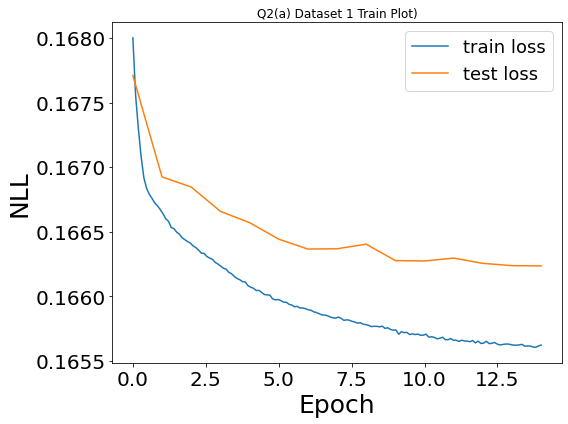

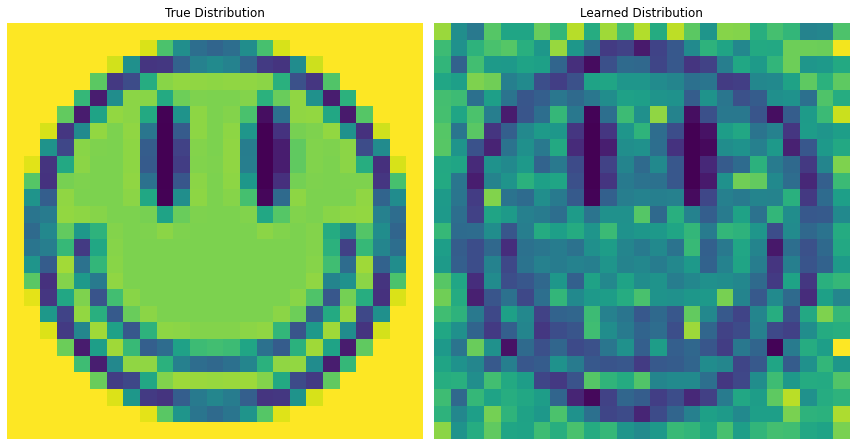

In [44]:
q1_save_results(1, 'a', made.train)

100%|██████████| 50/50 [09:19<00:00, 11.19s/it]


Final Test Loss: 0.0313


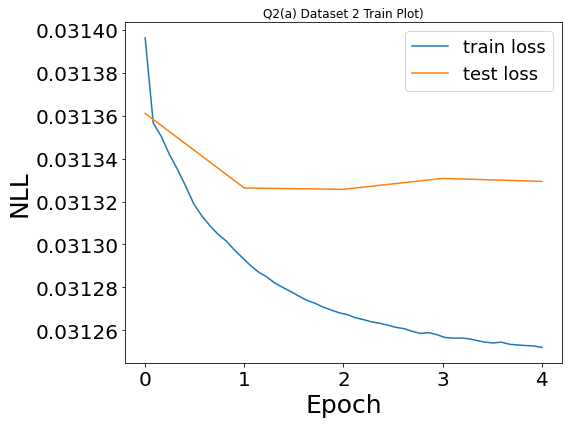

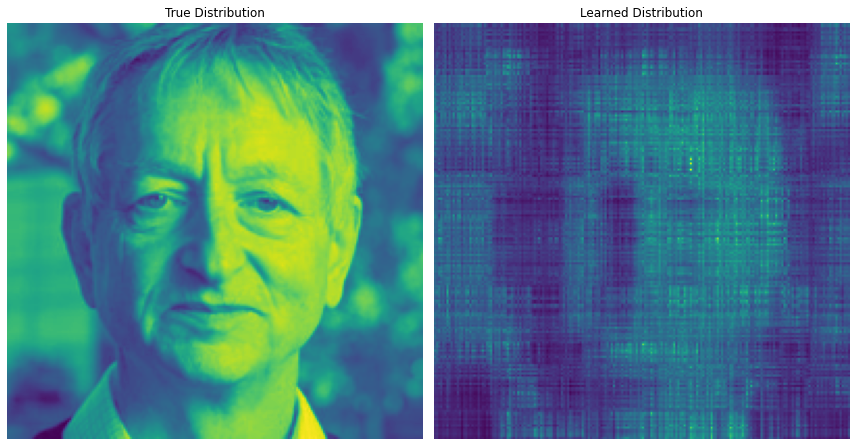

In [10]:
made = MADE(in_features=400, out_features=400, 
            hidden_features=32, hidden_sizes=[32, 32, 32], epochs=50, dims=200)
q1_save_results(2, 'a', made.train)

## Part (b) Shapes and MNIST
Now, we will work with a higher dimensional datasets, namely a shape dataset and MNIST. Run the cell below to visualize the two datasets

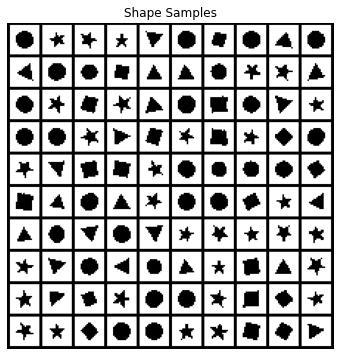

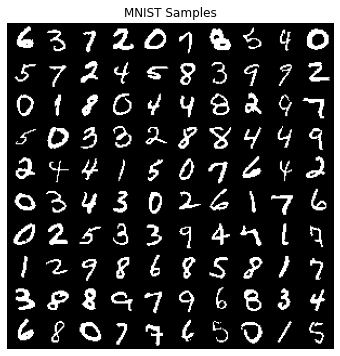

In [11]:
visualize_q1b_data(1)
visualize_q1b_data(2)
# you can access data with get_data_q1_b(dset_type=1)

Implement and train a MADE model on the given binary image datasets. Given some binary image of height $H$ and width $W$, we can represent image $x\in \{0, 1\}^{H\times W}$ as a flattened binary vector $x\in \{0, 1\}^{HW}$ to input into MADE to model $p_\theta(x) = \prod_{i=1}^{HW} p_\theta(x_i|x_{<i})$. Your model should output logits, after which you could apply a sigmoid over 1 logit, or a softmax over two logits (either is fine).

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [15]:
data = get_data_q1_b(dset_type=1)
data.reshape()

(10479, 20, 20, 1)

In [24]:
def get_dataloader(dataset, batch_size):
    new_dataset = torch.tensor(dataset.reshape(dataset.shape[0], -1)).float()
    return DataLoader(new_dataset, batch_size, pin_memory=True, 
               num_workers=2, shuffle=True)

In [58]:
class Model2(Model):
    def __init__(self, in_features, out_features, hidden_features):
        super().__init__(in_features, out_features, hidden_features)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        z = self.layers(x)
        z1 = self.sigmoid(z)
        z0 = torch.ones_like(z1) - z1
        return torch.stack([z0, z1], dim=1)

In [92]:
class MADE2(MADE):
    def __init__(self, in_features, out_features, 
                 hidden_features, hidden_sizes, batch_size=32, 
                 epochs=100, dims=25, lr=1e-3,
                 val_each=10, device="cuda"):
        super().__init__(in_features, out_features, 
                 hidden_features, hidden_sizes, batch_size, 
                 epochs, dims, lr, val_each, device)
        self.model = Model2(in_features, out_features, hidden_features)
        self.loss_func = nn.NLLLoss()

    def update_masks(self):
        self.m[-1] = np.arange(self.dim) 

        L = len(self.hidden_sizes)
        for l in range(L):
            self.m[l] = np.random.randint(self.m[l - 1].min(), 
                                        self.dim - 1, 
                                        size=self.hidden_sizes[l])     
        masks = [self.m[l - 1][:, np.newaxis] <= 
                 self.m[l][np.newaxis, :] for l in range(L)]
        masks.append(self.m[L - 1][:, np.newaxis] < self.m[-1][np.newaxis, :])

        layers = [l for l in self.model.modules() if isinstance(l, MaskedLinear)]
        for layer, mask in zip(layers, masks):
            layer.set_mask(mask)

    def loss(self, output, y):
        return self.loss_func(output, y.long())

    def train(self, train_data, val_data, image_shape=[20, 20], dset_id=None):
        train_dataloader = get_dataloader(train_data, self.batch_size)

        if val_data is not None:
            val_dataloader = get_dataloader(val_data, self.batch_size)

        self.model.to(self.device)
        for epoch in tqdm(range(self.epochs), position=0, leave=True):
            self.model.train()
            losses = []
            for batch in train_dataloader:
                self.optimizer.zero_grad()

                batch = batch.to(self.device)
                output = self.model(batch)
                loss = self.loss(output, batch)
                losses.append(loss.item())

                loss.backward()
                self.optimizer.step()

            self.train_loss.append(np.mean(losses))
            if epoch % self.val_each == 0 and val_data is not None:
                self.eval(val_dataloader)

        self.model.eval()
        h, w = image_shape
        imgs = torch.zeros(100, h * w).to(self.device)
        with torch.no_grad():
            for i in range(h * w):
                output = self.model(imgs).squeeze(-1)[:, :, i]
                imgs[:, i] = torch.multinomial(output, 1).squeeze(-1)
            imgs = imgs.view(100, 1, h, w)
            imgs = imgs.detach().cpu().numpy()

        return self.train_loss, self.val_loss, imgs.transpose(0, 2, 3, 1)



In [96]:
made2 = MADE2(in_features=400, out_features=400, hidden_features=128, hidden_sizes=[128, 128, 128],
      epochs=100, dims=400)

100%|██████████| 100/100 [02:05<00:00,  1.26s/it]


Final Test Loss: -0.4997


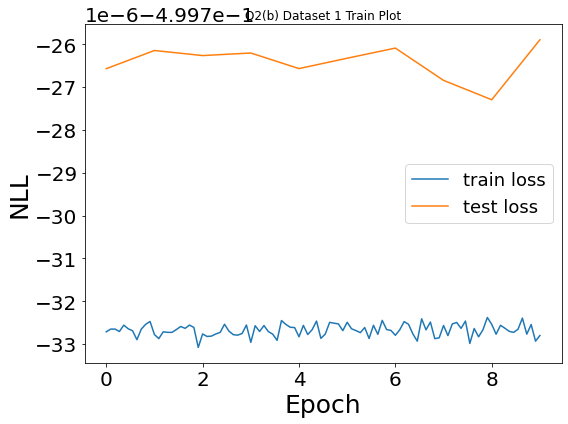

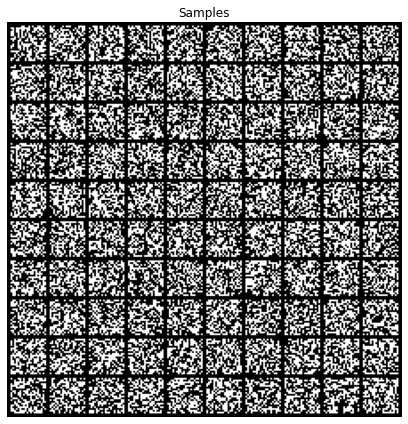

In [97]:
q1_save_results(1, 'b', made2.train)

100%|██████████| 100/100 [11:13<00:00,  6.74s/it]


Final Test Loss: -0.4995


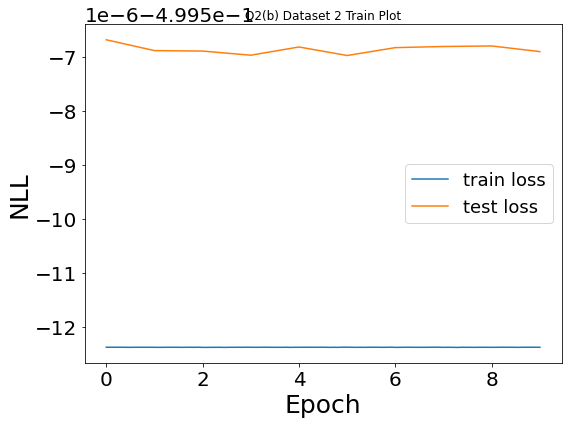

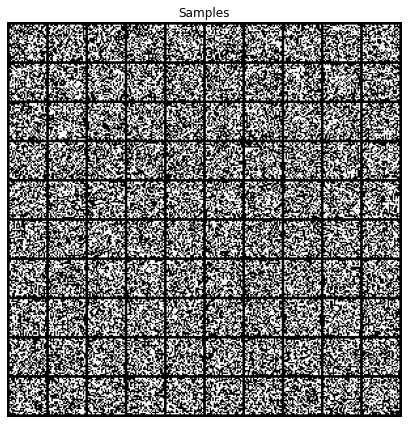

In [100]:
made2 = MADE2(in_features=784, out_features=784, hidden_features=128, hidden_sizes=[128, 128, 128],
      epochs=100, dims=784)
q1_save_results(2, 'b', made2.train)

In [98]:
def q1_b(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    test_data: An (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    image_shape: (H, W), height and width of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
            used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
    """

### Results

Once you've implemented `q2_b`, execute the cells below to visualize and save your results



Final Test Loss: 0.1371


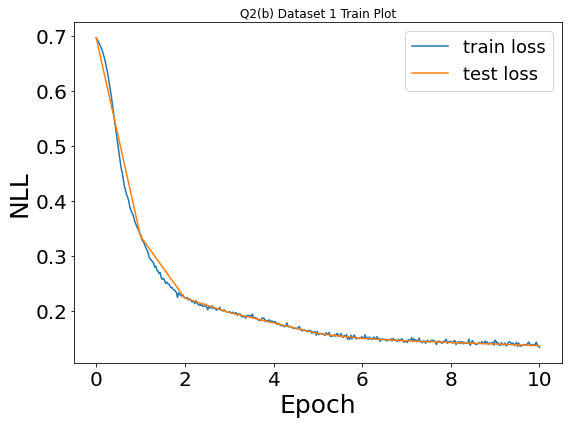

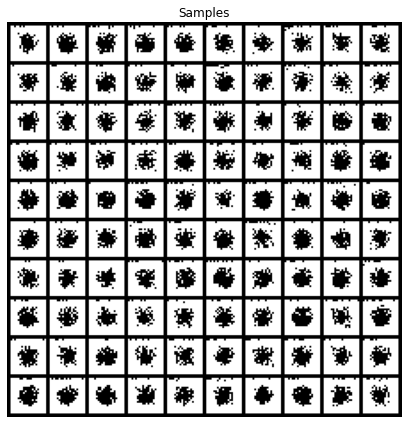

In [ ]:
q1_save_results(1, 'b', q1_b)

Final Test Loss: 0.1911


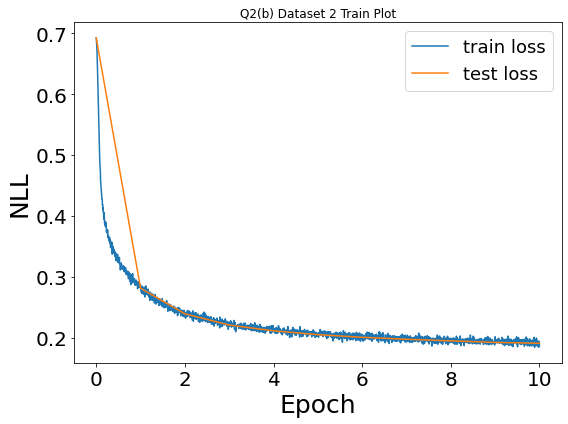

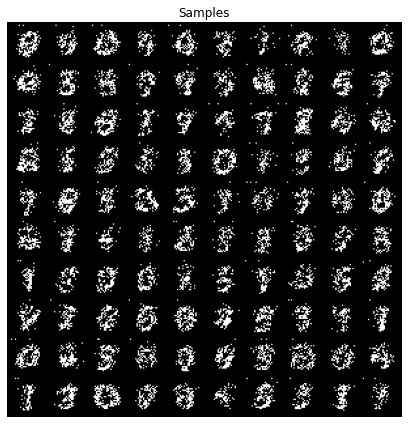

In [ ]:
q1_save_results(2, 'b', q1_b)